In [1]:
from nltk import CFG, ChartParser
from random import choice
from nltk.parse.generate import generate
import gensim
import os
import numpy as np
import cPickle as pickle
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pylab as plt
import random
from matplotlib import pyplot
import copy
import io
import pdb
NUM_ANALOGS = 4
N_COMPONENTS = 10
PER_ANALOG = 8

In [2]:
def reduce_word_embeddings(vec_dict,n_components=10):
    X_train = []
    X_train_names = []
    for x in vec_dict:
            X_train.append(vec_dict[x])
            X_train_names.append(x)

    X_train = np.asarray(X_train)
    pca_embeddings = {}

    # PCA to get Top Components
    pca =  PCA(n_components = len(X_train_names))
    X_train = X_train - np.mean(X_train)
    X_fit = pca.fit_transform(X_train)
    U1 = pca.components_

    z = []

    # Removing Projections on Top Components
    for i, x in enumerate(X_train):
        for u in U1[0:7]:        
                x = x - np.dot(u.transpose(),x) * u 
        z.append(x)

    z = np.asarray(z)

    # PCA Dim Reduction
    pca =  PCA(n_components = n_components)
    X_train = z - np.mean(z)
    X_new_final = pca.fit_transform(X_train)


    # PCA to do Post-Processing Again
    pca =  PCA(n_components = n_components)
    X_new = X_new_final - np.mean(X_new_final)
    X_new = pca.fit_transform(X_new)
    Ufit = pca.components_

    X_new_final = X_new_final - np.mean(X_new_final)

    final_pca_embeddings = {}

    for i, x in enumerate(X_train_names):
            final_pca_embeddings[x] = X_new_final[i]
            #for u in Ufit[0:7]:
            #    final_pca_embeddings[x] = final_pca_embeddings[x] - np.dot(u.transpose(),final_pca_embeddings[x]) * u 

    return final_pca_embeddings#X_new_final

In [3]:
# data is present in variable - stimuli
stimuli_path = str(os.path.dirname(os.getcwd())) + '\\data\\analog_3_stimuli.py'
f = open(stimuli_path, 'r')
f.seek(0)  # to get to the beginning of the file.
symstring = ''
for line in f:
    symstring += line
exec symstring

In [4]:
def vis_embeddings(vecs, names,save_path=None):
    X = vecs
    #pca = PCA(n_components=2)
    #result = pca.fit_transform(X)
    ## create a scatter plot of the projection
    #pyplot.scatter(result[:, 0], result[:, 1])
    
    #for i, word in enumerate(names):
    #    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    #pyplot.show()
    
    #cos_sim = np.dot(X, np.transpose(X))/(np.linalg.norm(X)*np.linalg.norm(X))
    cos_sim = np.corrcoef(X)
    sns_heatmap = sns.heatmap(cos_sim, linewidth=0.5,xticklabels=names, yticklabels=names)
    fig = sns_heatmap.get_figure()
    fig.savefig(save_path)
    plt.show()
    
    return

In [5]:
def getEmbeddings(embed_loc, wrd_list, embed_dims):
    """
    Gives embedding for each word in wrd_list
    Parameters
    ----------
    model:		Word2vec model
    wrd_list:	List of words for which embedding is required
    embed_dims:	Dimension of the embedding
    Returns
    -------
    embed_matrix:	(len(wrd_list) x embed_dims) matrix containing embedding for each word in wrd_list in the same order
    """
    embed_list = []

    wrd2embed = {}
    for line in io.open(embed_loc, encoding='utf-8'):
        data = line.strip().split(' ')

        # wrd, embed = data[0], data[1:]

        # Some words may be separated by space (telephone numbers, for example).
        # It's more robust to load data as follows.
        embed = data[-1*embed_dims: ] 
        wrd   = ' '.join(data[: -1*embed_dims])

        embed = list(map(float, embed))
        wrd2embed[wrd] = embed

    embeddings = {}
    for wrd in wrd_list:
        embeddings[wrd] = wrd2embed[wrd]
    
    return embeddings

In [8]:
os.path.dirname(os.getcwd())

'C:\\Users\\karkau\\Documents\\karthikeya\\Dora\\BrPong_1\\workspace\\karthikeya'

In [18]:
def get_word2vec(sentences,model_type='custom', reduced_dim=10, normalised=True):
    # first split all sentences and get unique words
    unique_words = [sentence.split(' ') for sentence in sentences]
    unique_words = [word.lower() for sentence in unique_words for word in sentence]
    unique_words = list(set(unique_words))
    # put these words into model and get embeddings
    if model_type == 'custom':
        # for custom model, give list of sentences
        all_sentences = [sentence.split(' ') for sentence in sentences]
        model_custom = gensim.models.Word2Vec(all_sentences, min_count=1,size=reduced_dim,sg=0) # sg= 1 - Skipgram, 0 - CBOW
        vec_dict = {}
        for word in unique_words:
            vec_dict[word] = model_custom[word]
    elif model_type == 'google':
        # for google word2vec give all unique words
        google_word2vec_path = 'C:\\Users\\karkau\\Documents\\karthikeya\\GoogleNews-vectors-negative300.bin'
        model = gensim.models.KeyedVectors.load_word2vec_format(
            google_word2vec_path, binary=True)
        vec_dict = {}
        for word in unique_words:
            vec_dict[word] = model[word]
        # reduce dimension size for the google 300b model
        vec_dict = reduce_word_embeddings(vec_dict,n_components=reduced_dim)
    elif model_type == 'WordGCN':
        model_path = 'C:\\Users\\karkau\\Documents\\karthikeya\\syngcn_embeddings.txt'
        vec_dict = getEmbeddings(model_path, unique_words, 300)
        vec_dict = reduce_word_embeddings(vec_dict, n_components=reduced_dim)
        
    # power normalise vectors, then put them into 0,1 range
    word2vec_mat = np.zeros((len(unique_words),reduced_dim))
    for ind,word in enumerate(unique_words):
        word2vec_mat[ind,:] = vec_dict[word]#/np.linalg.norm(vec_dict[word])
    # now 0-1 normalise by dimension
    for ind in range(word2vec_mat.shape[1]):
        word2vec_mat[:,ind] = (word2vec_mat[:,ind] - min(word2vec_mat[:,ind]))/(max(word2vec_mat[:,ind]) - min(word2vec_mat[:,ind]))
    # power normalise again
    for ind,word in enumerate(unique_words):
        word2vec_mat[ind,:] = word2vec_mat[ind,:]/np.linalg.norm(word2vec_mat[ind,:])
    
    # convert back to dict
    vec_dict = {}
    for ind,word in enumerate(unique_words):
        vec_dict[word] = word2vec_mat[ind,:]
    return [vec_dict, word2vec_mat, unique_words]

In [7]:
stimuli

['dogs chase cats',
 'hungry dogs bark',
 'dogs growl',
 'dogs think big dogs bite cats',
 'big dogs bite small cats',
 'angry hungry dogs growl at strangers',
 'kitten stay away from water',
 'cute fluffy cats purr softly',
 'lions hunt deer',
 'angry lions roar',
 'deer jump',
 'lions know big lions hunt deer',
 'bulky lions stalk fast deer',
 'majestic male lions roar in anger',
 'deer run quickly into darkness',
 'beautiful timid deer graze happily',
 'eagles eat worms',
 'majestic eagles glide',
 'eagles fly',
 'worms say early worms spot eagles',
 'wise eagles catch easy worms',
 'old bald eagles scan the sky',
 'worms crawl slowly from under',
 'slow dull worms wander aimlessly',
 'snakes eat rats',
 'angry snakes hiss',
 'snakes slither',
 'snakes think big snakes eat rats',
 'cunning snakes love juicy rats',
 'slender spotted snakes rattle at danger',
 'rats wobble quietly towards traps',
 'fat hairy rats scurry about']

In [27]:
[word2vec_dict, word2vec_mat, unique_words] = get_word2vec(sentences=stimuli,model_type='WordGCN',reduced_dim=N_COMPONENTS)
reduced_embeddings = word2vec_dict
sentences = stimuli
print(np.dot(reduced_embeddings['hungry'],reduced_embeddings['dogs']),
np.dot(reduced_embeddings['dogs'],reduced_embeddings['cats']),
np.dot(reduced_embeddings['dogs'],reduced_embeddings['jump']),
np.dot(reduced_embeddings['dogs'],reduced_embeddings['lions']),
np.dot(reduced_embeddings['bite'],reduced_embeddings['fast']),
np.dot(reduced_embeddings['bite'],reduced_embeddings['fly']))
#vis_embeddings(word2vec_mat,unique_words)
#print(np.dot(word2vec_dict['slender'],word2vec_dict['cats']))
#print(np.dot(word2vec_dict['nap'],word2vec_dict['fly']))
#print(np.dot(word2vec_dict['cats'],word2vec_dict['fly']))
#print(np.dot(word2vec_dict['bite'],word2vec_dict['fly']))
#print(np.dot(word2vec_dict['small'],word2vec_dict['big']))

(0.8968908589299879, 0.9919208743324607, 0.9017976931433493, 0.9016167440826438, 0.8290740386611384, 0.808014109088545)


In [10]:
def get_empty_vec(n_dim):
    sem = []#[['e0',1.0]] # change to [] and range(0,n_dim) to put empty vector. Here we need a specifier, and therefore not empty vec
    for i in range(0,n_dim):
        sem.append(['e' + str(i), 0.0])
    sem.append(['e' + str(n_dim), 1.0])
    return sem
def get_sem(word2vec_dict,word):
    vec = word2vec_dict[word]
    sem = []
    for i in range(len(vec)):
        sem.append(['e' + str(i), vec[i]])
    sem.append(['e' + str(len(vec)), 0.0])
    return sem

ValueError: fname must be a PathLike or file handle

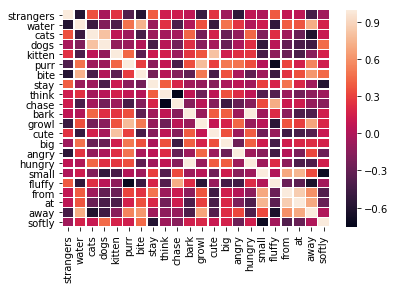

In [28]:
# test on two conditions - 
# words arranged within a single analog
# words arranged by lexical content across analogs
for i in [0]:#range(NUM_ANALOGS):
    analog_words = {}
    nouns = {}
    verbs = {}
    i_verbs = {}
    adj = {}
    prep = {}
    adverbs = {}
    for j in range(PER_ANALOG):
        sent = stimuli[i*PER_ANALOG + j]
        sent_words = sent.split(' ')
        for w in sent_words:
            analog_words[w] = reduced_embeddings[w]        
        # put words into different lexical categories  
        if j == 0:
            nouns[sent_words[0]],verbs[sent_words[1]],nouns[sent_words[2]] = reduced_embeddings[sent_words[0]], \
                reduced_embeddings[sent_words[1]],reduced_embeddings[sent_words[2]]
        if j == 1:
            adj[sent_words[0]],i_verbs[sent_words[2]] = reduced_embeddings[sent_words[0]],reduced_embeddings[sent_words[0]]
        if j == 2:
            i_verbs[sent_words[1]] = reduced_embeddings[sent_words[1]]
        if j == 3:
            verbs[sent_words[1]],adj[sent_words[2]],verbs[sent_words[4]] = reduced_embeddings[sent_words[1]], \
                reduced_embeddings[sent_words[2]],reduced_embeddings[sent_words[4]]
        if j == 4:
            adj[sent_words[0]],verbs[sent_words[2]],adj[sent_words[3]] = reduced_embeddings[sent_words[0]], \
                reduced_embeddings[sent_words[2]],reduced_embeddings[sent_words[3]]
        if j == 5:
            adj[sent_words[0]],adj[sent_words[1]],i_verbs[sent_words[3]],prep[sent_words[4]],nouns[sent_words[5]] = reduced_embeddings[sent_words[0]], \
                reduced_embeddings[sent_words[1]],reduced_embeddings[sent_words[3]],reduced_embeddings[sent_words[4]],reduced_embeddings[sent_words[5]]
        if j == 6:
            nouns[sent_words[0]],verbs[sent_words[1]],adverbs[sent_words[2]],prep[sent_words[3]],nouns[sent_words[4]] = reduced_embeddings[sent_words[0]], \
                reduced_embeddings[sent_words[1]],reduced_embeddings[sent_words[2]],reduced_embeddings[sent_words[3]],reduced_embeddings[sent_words[4]]
        if j == 7:
            adj[sent_words[0]],adj[sent_words[1]],verbs[sent_words[3]],adverbs[sent_words[4]] = reduced_embeddings[sent_words[0]], \
                reduced_embeddings[sent_words[1]],reduced_embeddings[sent_words[3]],reduced_embeddings[sent_words[4]]            
# now arrange them into a matrix, and send to visualisation function
all_dicts = [nouns, verbs, i_verbs, adj, prep, adverbs]
vis_matrix = np.zeros((len(analog_words.keys()),N_COMPONENTS))
vis_array_words = []
ind = 0
for d in all_dicts:
    for _,k in enumerate(d.keys()):
        vis_matrix[ind,:] = d[k]
        vis_array_words.append(k)
        ind = ind + 1
#np.savetxt(str(os.path.dirname(os.getcwd())) + '\\data\\embeddings\\cbow_embeddings.csv',vis_matrix)
#np.savetxt(str(os.path.dirname(os.getcwd())) + '\\data\\embeddings\\words.csv',np.array(vis_array_words),fmt="%s")
vis_embeddings(vis_matrix,vis_array_words)#, save_path=str(os.path.dirname(os.getcwd())) + '\\data\\word_embeddings_vis_cbow.png')

(22L, 10L)

In [10]:
# reduced_embeddings contains the word2vec
# type-1 with separate det for empty predicate
import copy
random.seed(999)
symProps = []
# for type = [0,1,2,3], [9,10,11]
prototype_1={'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
# for simple two word props like "happy cats" present in type = [4,5,6,7,8]
# 'name' is simply the proposition number + '.' + '1'
prototype_2 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}],
              'set':'memory','analog':None}
# for 3 word props in [4,5,6,7,8] containing prototype_2
prototype_3 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': True, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'non_exist', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
# for 6 word props in [16,17,18]
prototype_4 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': None, 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': True, 
                      'object_name': 'obj', 'object_sem': None, 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
#  for 5 word props in [19,20] 
prototype_5 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': True, 
                      'object_name': 'obj', 'object_sem': None, 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': True, 
                      'object_name': 'obj', 'object_sem': None, 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
#word2vec_dict = reduced_embeddings
for analog in range(0,NUM_ANALOGS): # 
    for proposition in range(0,PER_ANALOG):
        current_sentence = sentences[analog*PER_ANALOG + proposition]
        current_sentence = current_sentence.split(' ')
        # depending on proposition number, decompose propositions into their RB's
        if (proposition >=0 and proposition < 4) or (proposition >=9 and proposition < 12):
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['pred_name'] = 'det' # strange behaviour - predicate has to exist to form RB with P in object
            prop_dict['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['object_name'] = current_sentence[2]
            prop_dict['RBs'][1]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict['analog'] = analog
            #prop_dict['set'] = random.choice(['recipient','driver'])
            prop_dict['name'] = 'P' + str(proposition)
            symProps.append(prop_dict)
        elif proposition >=4 and proposition < 8:
            # first encode lower order prop
            prop_dict_1 = copy.deepcopy(prototype_2)
            prop_dict_1['name'] = 'P' + str(proposition) + '.1'
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[0]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[1]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict_1['analog'] = analog
            #prop_dict_1['set'] = random.choice(['recipient','driver'])
            symProps.append(prop_dict_1)
            # now encode the higher order sem
            prop_dict = copy.deepcopy(prototype_3)
            prop_dict['name'] = 'P' + str(proposition)
            prop_dict['RBs'][0]['pred_name'] = 'det' # strange behaviour - predicate has to exist to form RB with P in object
            prop_dict['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict['RBs'][0]['object_name'] = 'non_exist'#current_sentence[0] + current_sentence[1]
            prop_dict['RBs'][0]['object_sem'] = []
            prop_dict['RBs'][0]['P'] = 'P' + str(proposition) + '.1'
            prop_dict['RBs'][1]['pred_name'] = current_sentence[2]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict['analog'] = analog
            #prop_dict['set'] = random.choice(['recipient','driver'])
            symProps.append(prop_dict)
        elif proposition >= 12 and proposition < 16:
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['pred_name'] = 'det' # strange behaviour - predicate has to exist to form RB with P in object
            prop_dict['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(proposition)
            symProps.append(prop_dict)
        elif proposition >= 16 and proposition < 19:
            prop_dict_1 = copy.deepcopy(prototype_2)
            prop_dict_1['name'] = 'P' + str(proposition) + '.1'
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[2]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[3]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_1['analog'] = analog
            symProps.append(prop_dict_1)
            # add higher order prop
            prop_dict_2 = copy.deepcopy(prototype_3)
            prop_dict_2['name'] = 'P' + str(proposition) + '.2'
            prop_dict_2['RBs'][0]['P'] = 'P' + str(proposition) + '.1'
            prop_dict_2['RBs'][0]['pred_name'] = 'det'
            prop_dict_2['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict_2['RBs'][1]['pred_name'] = current_sentence[4]
            prop_dict_2['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[4])
            prop_dict_2['RBs'][1]['object_name'] = current_sentence[5]
            prop_dict_2['RBs'][1]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[5])
            prop_dict_2['analog'] = analog
            symProps.append(prop_dict_2)
            # now add the highest order prop
            prop_dict = copy.deepcopy(prototype_4)
            prop_dict['name'] = 'P' + str(proposition)
            prop_dict['RBs'][0]['pred_name'] = 'det'
            prop_dict_2['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)            
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['P'] = 'P' + str(proposition) + '.1'
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(proposition)
            symProps.append(prop_dict)
        elif proposition >= 19 and proposition < 21:
            prop_dict_1 = copy.deepcopy(prototype_2)
            prop_dict_1['name'] = 'P' + str(proposition) + '.1'
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[0]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[1]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict_1['analog'] = analog
            symProps.append(prop_dict_1)
            prop_dict_1 = copy.deepcopy(prototype_2)
            prop_dict_1['name'] = 'P' + str(proposition) + '.2'
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[3]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[4]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[4])
            prop_dict_1['analog'] = analog
            symProps.append(prop_dict_1)
            prop_dict = copy.deepcopy(prototype_5)
            prop_dict['name'] = 'P' + str(proposition)
            prop_dict['RBs'][0]['P'] = 'P' + str(proposition) + '.1'
            prop_dict['RBs'][0]['pred_name'] = 'det'
            prop_dict['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict['RBs'][1]['P'] = 'P' + str(proposition) + '.2'
            prop_dict['RBs'][1]['pred_name'] = current_sentence[2]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict['analog'] = analog
            symProps.append(prop_dict)
        elif proposition >= 21 and proposition < 23:
            prop_dict_1 = copy.deepcopy(prototype_2)
            prop_dict_1['name'] = 'P' + str(proposition) + '.1'
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[2]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[3]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_1['analog'] = analog
            symProps.append(prop_dict_1)
            # add higher order prop
            prop_dict = copy.deepcopy(prototype_4)
            prop_dict['name'] = 'P' + str(proposition)
            prop_dict['RBs'][0]['pred_name'] = 'det'
            prop_dict['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['P'] = 'P' + str(proposition) + '.1'
            prop_dict['analog'] = analog
            symProps.append(prop_dict)

In [58]:
# type 2 with filled in slot like structure. ie., no empty predicate 
# reduced_embeddings contains the word2vec
random.seed(999)
symProps = []
# for type = [0,1,2,3], [9,10,11]
prototype_1={'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
# for 3 word props in [4,5,6,7,8] containing prototype_1
prototype_2 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': True, 
                      'object_name': 'non_exist', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
# for 2 word prop = single RB
prototype_3 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}

#word2vec_dict = reduced_embeddings
for analog in range(0,NUM_ANALOGS): # 
    for proposition in range(0,PER_ANALOG):
        current_sentence = sentences[analog*PER_ANALOG + proposition]
        current_sentence = current_sentence.split(' ')
        # depending on proposition number, decompose propositions into their RB's
        if (proposition >=0 and proposition < 4) or (proposition >=9 and proposition < 12): # == [- dogs][bite cats]
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['object_name'] = current_sentence[2]
            prop_dict['RBs'][1]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition >=4 and proposition < 9: # == [happy cats][sleep -]
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['pred_name'] = current_sentence[0] 
            prop_dict['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][0]['object_name'] = current_sentence[1]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[2]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition >= 12 and proposition < 16: # == [- eagles][fly -]
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        '''elif proposition >= 16 and proposition < 19: # == [- dogs][think [[big dogs][bite cats]]
            prop_dict_1 = copy.deepcopy(prototype_1) # == [[big dogs][bite cats]]
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[2]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[3]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_1['RBs'][1]['pred_name'] = current_sentence[4]
            prop_dict_1['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[4])
            prop_dict_1['RBs'][1]['object_name'] = current_sentence[5]
            prop_dict_1['RBs'][1]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[5])
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'
            symProps.append(prop_dict_1)
            # add higher order prop 
            prop_dict = copy.deepcopy(prototype_2) # == [- dogs][think P-N.1]
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['P'] = 'P' + str(analog) + str(proposition) + '.1'
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition >= 19 and proposition < 21: # == [big dogs][bite [small cats]]
            prop_dict_1 = copy.deepcopy(prototype_3) # [small cats]
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[3]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[4]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[4])
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'            
            symProps.append(prop_dict_1)
            prop_dict = copy.deepcopy(prototype_2) # == [big dogs][bite P-N.1]
            prop_dict['RBs'][0]['pred_name'] = current_sentence[0]
            prop_dict['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][0]['object_name'] = current_sentence[1]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[2]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict['RBs'][1]['P'] = 'P' + str(analog) + str(proposition) + '.1'
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition >= 21 and proposition < 23: # == [- lions][hunt [fast deer]]
            prop_dict_1 = copy.deepcopy(prototype_3)
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[2]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[3]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'        
            symProps.append(prop_dict_1)
            # add higher order prop
            prop_dict = copy.deepcopy(prototype_2)
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['P'] = 'P' + str(analog) + str(proposition) + '.1'
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)            
            symProps.append(prop_dict)'''

10

In [25]:
# type 3 sym setup - 4 analogs consisting of 5 sentence types
random.seed(999)
symProps = []
# for type = [0,1,2,3], [9,10,11]
prototype_1={'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
# for 3 word props in [4,5,6,7,8] containing prototype_1
prototype_2 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': True, 
                      'object_name': 'non_exist', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
# for 2 word prop = single RB
prototype_3 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}

#word2vec_dict = reduced_embeddings
for analog in range(0,NUM_ANALOGS): # 
    for proposition in range(0,PER_ANALOG):
        current_sentence = sentences[analog*PER_ANALOG + proposition]
        current_sentence = current_sentence.split(' ')
        # depending on proposition number, decompose propositions into their RB's
        if proposition == 0: # == [- dogs][bite cats]
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['pred_name'] = 'det'
            prop_dict['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            #prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['object_name'] = current_sentence[2]
            prop_dict['RBs'][1]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition == 1: # == [happy cats][sleep -]
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['pred_name'] = current_sentence[0] 
            prop_dict['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][0]['object_name'] = current_sentence[1]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[2]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition == 2: # == [- eagles][fly -]
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['pred_name'] = 'det'
            prop_dict['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            #prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition == 3: # == [- dogs][think [[big dogs][bite cats]]
            prop_dict_1 = copy.deepcopy(prototype_1) # == [[big dogs][bite cats]]
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[2]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[3]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_1['RBs'][1]['pred_name'] = current_sentence[4]
            prop_dict_1['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[4])
            prop_dict_1['RBs'][1]['object_name'] = current_sentence[5]
            prop_dict_1['RBs'][1]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[5])
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'
            symProps.append(prop_dict_1)
            # add higher order prop 
            prop_dict = copy.deepcopy(prototype_2) # == [- dogs][think P-N.1]
            prop_dict['RBs'][0]['pred_name'] = 'det'
            prop_dict['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['P'] = 'P' + str(analog) + str(proposition) + '.1'
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition == 4: # == [big dogs][bite [small cats]]
            prop_dict_1 = copy.deepcopy(prototype_3) # [small cats]
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[3]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[4]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[4])
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'            
            symProps.append(prop_dict_1)
            prop_dict = copy.deepcopy(prototype_2) # == [big dogs][bite P-N.1]
            prop_dict['RBs'][0]['pred_name'] = current_sentence[0]
            prop_dict['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict['RBs'][0]['object_name'] = current_sentence[1]
            prop_dict['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict['RBs'][1]['pred_name'] = current_sentence[2]
            prop_dict['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict['RBs'][1]['P'] = 'P' + str(analog) + str(proposition) + '.1'
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition == 5: # == [[angry [hungry dogs]] [growl [at strangers]]]
            prop_dict_1 = copy.deepcopy(prototype_3) # [hungry dogs]
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[1]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[2]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'            
            symProps.append(prop_dict_1)
            prop_dict_2 = copy.deepcopy(prototype_3)
            prop_dict_2['RBs'][0]['pred_name'] = current_sentence[4] # [at strangers]
            prop_dict_2['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[4])
            prop_dict_2['RBs'][0]['object_name'] = current_sentence[5]
            prop_dict_2['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[5])
            prop_dict_2['analog'] = analog
            prop_dict_2['name'] = 'P' + str(analog) + str(proposition) + '.2'                        
            symProps.append(prop_dict_2)
            prop_dict_3 = copy.deepcopy(prototype_2) # [angry [P N.1]] [growl [P N.2]]
            prop_dict_3['RBs'][0]['pred_name'] = current_sentence[0]
            prop_dict_3['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict_3['RBs'][0]['higher_order'] = True
            prop_dict_3['RBs'][0]['P'] = 'P' + str(analog) + str(proposition) + '.1'
            prop_dict_3['RBs'][1]['pred_name'] = current_sentence[3]
            prop_dict_3['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_3['RBs'][1]['higher_order'] = True
            prop_dict_3['RBs'][1]['P'] = 'P' + str(analog) + str(proposition) + '.2'            
            prop_dict_3['analog'] = analog
            prop_dict_3['name'] = 'P' + str(analog) + str(proposition)            
            symProps.append(prop_dict_3)                  
        elif proposition == 6: # [kitten [stay [away [from water]]]]
            prop_dict_1 = copy.deepcopy(prototype_3)
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[3] # [from water]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[4]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[4])
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'
            symProps.append(prop_dict_1)
            prop_dict_2 = copy.deepcopy(prototype_3) # [away [P N.1]]
            prop_dict_2['RBs'][0]['pred_name'] = current_sentence[2]
            prop_dict_2['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict_2['RBs'][0]['higher_order'] = True
            prop_dict_2['RBs'][0]['P'] = 'P' + str(analog) + str(proposition) + '.1'
            prop_dict_2['analog'] = analog
            prop_dict_2['name'] = 'P' + str(analog) + str(proposition) + '.2'
            symProps.append(prop_dict_2)
            prop_dict_3 = copy.deepcopy(prototype_2) # [- kitten] [stay [P N.2]]  OR [kitten PN.3] ?! (kitten is not the predicate)
            prop_dict_3['RBs'][0]['pred_name'] = 'det'
            prop_dict_3['RBs'][0]['pred_sem'] = get_empty_vec(n_dim=N_COMPONENTS)
            prop_dict_3['RBs'][0]['object_name'] = current_sentence[0]
            prop_dict_3['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict_3['RBs'][1]['pred_name'] = current_sentence[1]
            prop_dict_3['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict_3['RBs'][1]['higher_order'] = True
            prop_dict_3['RBs'][1]['P'] = 'P' + str(analog) + str(proposition) + '.2'            
            prop_dict_3['analog'] = analog
            prop_dict_3['name'] = 'P' + str(analog) + str(proposition)            
            symProps.append(prop_dict_3)
        elif proposition == 7: # [[cute [fluffy cats]] [purr softly]]
            prop_dict_1 = copy.deepcopy(prototype_3)
            prop_dict_1['RBs'][0]['pred_name'] = current_sentence[1] # [fluffy cats]
            prop_dict_1['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[1])
            prop_dict_1['RBs'][0]['object_name'] = current_sentence[2]
            prop_dict_1['RBs'][0]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[2])
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'
            symProps.append(prop_dict_1)
            prop_dict_2 = copy.deepcopy(prototype_2) # [cute PN.1] [purr softly]
            prop_dict_2['RBs'][0]['pred_name'] = current_sentence[0]
            prop_dict_2['RBs'][0]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[0])
            prop_dict_2['RBs'][0]['higher_order'] = True
            prop_dict_2['RBs'][0]['P'] = 'P' + str(analog) + str(proposition) + '.1'            
            prop_dict_2['RBs'][1]['higher_order'] = False
            prop_dict_2['RBs'][1]['pred_name'] = current_sentence[3]
            prop_dict_2['RBs'][1]['pred_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[3])
            prop_dict_2['RBs'][1]['object_name'] = current_sentence[4]
            prop_dict_2['RBs'][1]['object_sem'] = get_sem(word2vec_dict=reduced_embeddings,word=current_sentence[4])            
            prop_dict_2['analog'] = analog
            prop_dict_2['name'] = 'P' + str(analog) + str(proposition)            
            symProps.append(prop_dict_2)
''''''

''

In [22]:
get_sem(word2vec_dict=reduced_embeddings,word='snakes')
#get_empty_vec(n_dim=N_COMPONENTS)

[['e0', 0.06480299358623666],
 ['e1', 0.410369420308889],
 ['e2', 0.08415358252775379],
 ['e3', 0.20782311894926406],
 ['e4', 0.4601755301390137],
 ['e5', 0.23720713003764196],
 ['e6', 0.223714081131958],
 ['e7', 0.31554810590104265],
 ['e8', 0.35444081652806214],
 ['e9', 0.48357998918545486],
 ['e10', 0.0]]

In [50]:
# initialising lexical one hot vecs :
# categories - noun, transitive verb, intransitive verb, adjective, complementizer verb, and empty sem
noun = [['e0',1],['e1',0],['e2',0],['e3',0],['e4',0],['e5',0]]
t_verb = [['e0',0],['e1',1],['e2',0],['e3',0],['e4',0],['e5',0]]
it_verb = [['e0',0],['e1',0],['e2',1],['e3',0],['e4',0],['e5',0]]
adj = [['e0',0],['e1',0],['e2',0],['e3',1],['e4',0],['e5',0]]
c_verb = [['e0',0],['e1',0],['e2',0],['e3',0],['e4',1],['e5',0]]
empty_sem = [['e0',0],['e1',0],['e2',0],['e3',0],['e4',0],['e5',1]]

In [78]:
# type 4 sym setup - 4 analogs consisting of 5 sentence types, with lexical one hot encoding only
random.seed(999)
symProps = []
# for type = [0,1,2,3], [9,10,11]
prototype_1={'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
# for 3 word props in [4,5,6,7,8] containing prototype_1
prototype_2 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}, 
                     {'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': True, 
                      'object_name': 'non_exist', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}
# for 2 word prop = single RB
prototype_3 = {'name': 'non_exist', 
             'RBs': [{'pred_name': 'non_exist', 'pred_sem': [], 
                      'higher_order': False, 
                      'object_name': 'obj', 'object_sem': [], 'P': 'non_exist'}], 
             'set': 'memory', 'analog': None}

#word2vec_dict = reduced_embeddings
for analog in range(0,NUM_ANALOGS): # 
    for proposition in range(0,PER_ANALOG):
        current_sentence = sentences[analog*PER_ANALOG + proposition]
        current_sentence = current_sentence.split(' ')
        # depending on proposition number, decompose propositions into their RB's
        if proposition == 0: # == [- dogs][bite cats]
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['pred_name'] = 'noun'
            prop_dict['RBs'][0]['pred_sem'] = noun
            #prop_dict['RBs'][0]['object_name'] = 'noun'
            #prop_dict['RBs'][0]['object_sem'] = noun
            prop_dict['RBs'][1]['pred_name'] = 't_verb'
            prop_dict['RBs'][1]['pred_sem'] = t_verb
            prop_dict['RBs'][1]['object_name'] = 'noun'
            prop_dict['RBs'][1]['object_sem'] = noun
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition == 1: # == [happy cats][sleep -]
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['pred_name'] = 'adj'
            prop_dict['RBs'][0]['pred_sem'] = adj
            prop_dict['RBs'][0]['object_name'] = 'noun'
            prop_dict['RBs'][0]['object_sem'] = noun
            prop_dict['RBs'][1]['pred_name'] = 'it_verb'
            prop_dict['RBs'][1]['pred_sem'] = it_verb
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition == 2: # == [- eagles][fly -]
            prop_dict = copy.deepcopy(prototype_1)
            prop_dict['RBs'][0]['pred_name'] = 'noun'
            prop_dict['RBs'][0]['pred_sem'] = noun
            #prop_dict['RBs'][0]['object_name'] = 'noun'
            #prop_dict['RBs'][0]['object_sem'] = noun
            prop_dict['RBs'][1]['pred_name'] = 'it_verb'
            prop_dict['RBs'][1]['pred_sem'] = it_verb
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition == 3: # == [- dogs][think [[big dogs][bite cats]]
            prop_dict_1 = copy.deepcopy(prototype_1) # == [[big dogs][bite cats]]
            prop_dict_1['RBs'][0]['pred_name'] = 'adj'
            prop_dict_1['RBs'][0]['pred_sem'] = adj
            prop_dict_1['RBs'][0]['object_name'] = 'noun'
            prop_dict_1['RBs'][0]['object_sem'] = noun
            prop_dict_1['RBs'][1]['pred_name'] = 't_verb'
            prop_dict_1['RBs'][1]['pred_sem'] = t_verb
            prop_dict_1['RBs'][1]['object_name'] = 'noun'
            prop_dict_1['RBs'][1]['object_sem'] = noun
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'
            symProps.append(prop_dict_1)
            # add higher order prop 
            prop_dict = copy.deepcopy(prototype_2) # == [- dogs][think P-N.1]
            prop_dict['RBs'][0]['pred_name'] = 'noun'
            prop_dict['RBs'][0]['pred_sem'] = noun
            #prop_dict['RBs'][0]['object_name'] = 'noun'
            #prop_dict['RBs'][0]['object_sem'] = noun
            prop_dict['RBs'][1]['pred_name'] = 'c_verb'
            prop_dict['RBs'][1]['pred_sem'] = c_verb
            prop_dict['RBs'][1]['P'] = 'P' + str(analog) + str(proposition) + '.1'
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
        elif proposition == 4: # == [big dogs][bite [small cats]]
            prop_dict_1 = copy.deepcopy(prototype_3) # [small cats]
            prop_dict_1['RBs'][0]['pred_name'] = 'adj'
            prop_dict_1['RBs'][0]['pred_sem'] = adj
            prop_dict_1['RBs'][0]['object_name'] = 'noun'
            prop_dict_1['RBs'][0]['object_sem'] = noun
            prop_dict_1['analog'] = analog
            prop_dict_1['name'] = 'P' + str(analog) + str(proposition) + '.1'            
            symProps.append(prop_dict_1)
            prop_dict = copy.deepcopy(prototype_2) # == [big dogs][bite P-N.1]
            prop_dict['RBs'][0]['pred_name'] = 'adj'
            prop_dict['RBs'][0]['pred_sem'] = adj
            prop_dict['RBs'][0]['object_name'] = 'noun'
            prop_dict['RBs'][0]['object_sem'] = noun
            prop_dict['RBs'][1]['pred_name'] = 't_verb'
            prop_dict['RBs'][1]['pred_sem'] = t_verb
            prop_dict['RBs'][1]['P'] = 'P' + str(analog) + str(proposition) + '.1'
            prop_dict['analog'] = analog
            prop_dict['name'] = 'P' + str(analog) + str(proposition)
            symProps.append(prop_dict)
            # add a proposition that is the reverse of proposition 4, to see how it behaves:
            
''''''

''

In [19]:
get_empty_vec(n_dim=N_COMPONENTS)

[['e0', 0.0], ['e1', 0.0], ['e2', 0.0], ['e3', 0.0], ['e4', 0.0], ['e5', 1.0]]

In [26]:
# convert symProps dict to text and write to python file
test_sim_path = str(os.path.dirname(os.getcwd())) + '\\test_sim_custom-WordGCN-7-empty_pred.py'
write_file = open(test_sim_path, 'w')
simType = 'sym_file'
write_file.write("simType='sym_file'\n")
write_file.write("symProps=")
write_file.write(str(symProps))
write_file.close()

In [83]:
# tests : 
# hungry dogs bark -- deer are beautiful
# hungry dogs is closer to are beautiful, than hungry dogs to happy cats
# compare with word embedding distances
print(np.dot(reduced_embeddings['think'],reduced_embeddings['say']),
np.dot(reduced_embeddings['think'],reduced_embeddings['easy']),
np.dot(reduced_embeddings['hungry'],reduced_embeddings['majestic']),
np.dot(reduced_embeddings['hungry'],reduced_embeddings['say']),
np.dot(reduced_embeddings['easy'],reduced_embeddings['say']),
np.dot(reduced_embeddings['easy'],reduced_embeddings['small']))
#np.dot(reduced_embeddings['dogs'],reduced_embeddings['cats']),
#np.dot(reduced_embeddings['dogs'],reduced_embeddings['beautiful']),)

(0.9642436703816699, 0.7648118897384594, 0.6713845447337492, 0.5863380140569783, 0.7189319440521685, 0.9305206857412015)


In [21]:
for word in unique_words:
    print(word, ' : cats', np.dot(reduced_embeddings['cats'],reduced_embeddings[word]))

('bulky', ' : cats', 0.8996268858494894)
('deer', ' : cats', 0.820462193248583)
('worms', ' : cats', 0.6502365789785044)
('jump', ' : cats', 0.6323390693496724)
('say', ' : cats', 0.9027534281245476)
('majestic', ' : cats', 0.8550571610386262)
('bark', ' : cats', 0.7878160179016085)
('growl', ' : cats', 0.6755928010050203)
('glide', ' : cats', 0.8397984004420732)
('bite', ' : cats', 0.7403121271920742)
('fast', ' : cats', 0.7254383669191854)
('cats', ' : cats', 1.0)
('lions', ' : cats', 0.764426044970141)
('easy', ' : cats', 0.8910096864477822)
('eagles', ' : cats', 0.8890342490947979)
('angry', ' : cats', 0.7780345444718267)
('dogs', ' : cats', 0.7571206678669506)
('big', ' : cats', 0.9041580455034262)
('spot', ' : cats', 0.7588218594637269)
('early', ' : cats', 0.8394382787546042)
('know', ' : cats', 0.8519041673856597)
('catch', ' : cats', 0.9421742716964969)
('eat', ' : cats', 0.7949577087911066)
('fly', ' : cats', 0.7605063106469391)
('wise', ' : cats', 0.6889790913834667)
('roar'

In [29]:
import pickle as pkl

'C:\\Users\\karkau\\Documents\\karthikeya\\Dora\\BrPong_1\\workspace\\karthikeya\\data\\results\\wordgcn\\WordGCN.pkl'

In [33]:
temp_file= open(str(os.path.dirname(os.getcwd())) + '\\data\\results\\wordgcn\\WordGCN.pkl', 'rb')

In [34]:
temp_data= pkl.load(temp_file)

In [35]:
temp_data

{0: [[1.0,
   0.4000000000000001,
   0.4375,
   0.4117647058823529,
   0.3888888888888889,
   0.43805718578657793,
   0.43550332807480685,
   0.43550332807480685,
   0.39704178961326847,
   0.4569161461205482,
   0.4505581301130532,
   0.4446081860188387,
   0.4306723589191704,
   0.4024753179687956,
   0.4084839604827696,
   0.4398048837010607,
   0.4146731760610001,
   0.43095264842343484,
   0.43095264842343484,
   0.4404850517744469,
   0.4285800503751375,
   0.45358225767405275,
   0.45358225767405275,
   0.48393879891438324,
   0.4594958907259751,
   0.472606242620821,
   0.487256069214687,
   0.48104921906600495,
   0.47948321062978466,
   0.47946544140079755,
   0.49529280323533403,
   0.5672767734167177,
   0.5710509238700896,
   0.580129571960611,
   0.6116819720549431,
   0.6116819720549431,
   0.6258853495555361,
   0.6395590602290292,
   0.6538582402804481,
   0.6399502141684592,
   0.6156612089185731,
   0.6156612089185731,
   0.6375908465516077,
   0.6380179462956389,
  

In [40]:
temp1 = [[]]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])